In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Configurar dispositivo para GPU si está disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Usando el dispositivo: {device}')

Usando el dispositivo: cuda:0


In [29]:
# Cargar el modelo y el tokenizador pre-entrenado
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=7)
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
# Mover el modelo a la GPU si está disponible
model.to(device='cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

PREPARACION DE LOS DATOS

In [31]:
# seleccionamos el arhchivo datos_editados_18.95.csv

from google.colab import files

# Cargar el archivo desde el sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Listar los archivos en el directorio actual
!ls

# Obtener la ruta del archivo en el sistema de archivos de Colab
import os
current_directory = os.getcwd()
file_path = os.path.join(current_directory, file_name)
print("Ruta del archivo:", file_path)

Saving datos_tfm.csv to datos_tfm (1).csv
'datos_tfm (1).csv'   datos_tfm.csv   sample_data
Ruta del archivo: /content/datos_tfm (1).csv


In [32]:
datos_editados = pd.read_csv("datos_tfm.csv",encoding='latin1') # estos datos los hemos extraido de manera previa uniendo la variable "4"="CAOS" para ver si tenían mas relacion

In [33]:
print(len(datos_editados)) #1013

1388


In [39]:
# En los datos de entrenamiento tendría que haber informacion suficiente para entrenar de todas las variables ( a destacar la variable 4 (CAOS))
train_texts, test_texts, train_labels, test_labels = train_test_split(datos_editados['Frase'], datos_editados['Consensuada'], test_size=0.2, random_state=42,stratify=datos_editados['Consensuada'] )


In [40]:
y = datos_editados.Consensuada

In [41]:
# RECUENTO POR CADA CLASE de la variable "Consensuada"
unique, counts = np.unique(y, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TOTAL %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TOTAL 0: Samples 275
Consensuada TOTAL 1: Samples 290
Consensuada TOTAL 2: Samples 456
Consensuada TOTAL 3: Samples 196
Consensuada TOTAL 4: Samples 171


In [42]:
# RECUENTO EN LOS DATOS DE ENTRENAMIENTO
unique, counts = np.unique(train_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TRAIN %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TRAIN 0: Samples 220
Consensuada TRAIN 1: Samples 232
Consensuada TRAIN 2: Samples 364
Consensuada TRAIN 3: Samples 157
Consensuada TRAIN 4: Samples 137


In [43]:
# Veamos ahora el recuento en los DATOS DE TEST
# Number of samples per class
unique, counts = np.unique(test_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TEST %i: Samples %i' % (unique[i], counts[i]) )
# efectivamente está mal porque

Consensuada TEST 0: Samples 55
Consensuada TEST 1: Samples 58
Consensuada TEST 2: Samples 92
Consensuada TEST 3: Samples 39
Consensuada TEST 4: Samples 34


In [ ]:
!pip install transformers

In [ ]:
# Tokenización y creación de datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True) #,max_length=64)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True) #,max_length=64)

In [ ]:
train_labels = torch.tensor(train_labels.tolist()).to(device='cuda:0')
test_labels = torch.tensor(test_labels.tolist()).to(device='cuda:0')

## Convertimos ahora los datos a tensores de PyTorch

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(train_encodings['attention_mask']).to(device='cuda:0'),
    train_labels
)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(test_encodings['attention_mask']).to(device='cuda:0'),
    test_labels
)

## Definimos el DataLoader para cargar los datos durante el entrenamiento

In [ ]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Optimizador y funcion de perdida

In [ ]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer = AdamW(model.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
training_loss = []
training_accuracy = []

for epoch in range(30):  # Cambia el número de épocas según necesites
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    train_accuracy = correct_predictions / total_predictions
    training_loss.append(total_loss / len(train_dataloader))
    training_accuracy.append(train_accuracy)

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}")
    print(f"Training Loss: {training_loss[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print("-" * 50)

Epoch 1
Training Loss: 1.4426, Training Accuracy: 0.4272
--------------------------------------------------
Epoch 2
Training Loss: 1.0861, Training Accuracy: 0.6148
--------------------------------------------------
Epoch 3
Training Loss: 0.7540, Training Accuracy: 0.7531
--------------------------------------------------
Epoch 4
Training Loss: 0.4730, Training Accuracy: 0.8568
--------------------------------------------------
Epoch 5
Training Loss: 0.2458, Training Accuracy: 0.9370
--------------------------------------------------
Epoch 6
Training Loss: 0.1488, Training Accuracy: 0.9630
--------------------------------------------------
Epoch 7
Training Loss: 0.1015, Training Accuracy: 0.9741
--------------------------------------------------
Epoch 8
Training Loss: 0.0823, Training Accuracy: 0.9778
--------------------------------------------------
Epoch 9
Training Loss: 0.0815, Training Accuracy: 0.9728
--------------------------------------------------
Epoch 10
Training Loss: 0.08




```
# max_length = 512
# lr = 2e-5
# stratify=datos_editados['Consensuada']
```



In [ ]:
model.train()
for epoch in range(40):  # Cambia el número de épocas según necesites
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    accuracy = correct_predictions / total_predictions

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}, Loss: {total_loss}, Accuracy: {accuracy}")



KeyboardInterrupt: 

## evaluacion del conjunto de pruebas

In [ ]:
validation_loss = []
validation_accuracy = []
model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            input_ids, attention_mask, labels = batch
            # Asegurarse de que los datos estén en el mismo dispositivo que el modelo
            input_ids = input_ids.to(model.device)
            attention_mask = attention_mask.to(model.device)
            labels = labels.to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_predictions += len(labels)


IndentationError: unexpected indent (<ipython-input-45-4ffdbbbeacaa>, line 4)

In [ ]:
# Evaluación del modelo
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
class_names = ['SE', 'AA', 'E', 'CON','CA']


NameError: name 'confusion_matrix' is not defined

In [ ]:
# Impresión de métricas de evaluación
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.62      0.66        55
           1       0.64      0.76      0.69        58
           2       0.91      0.88      0.90        92
           3       0.47      0.46      0.47        39
           4       0.76      0.76      0.76        34

    accuracy                           0.73       278
   macro avg       0.70      0.70      0.70       278
weighted avg       0.73      0.73      0.73       278



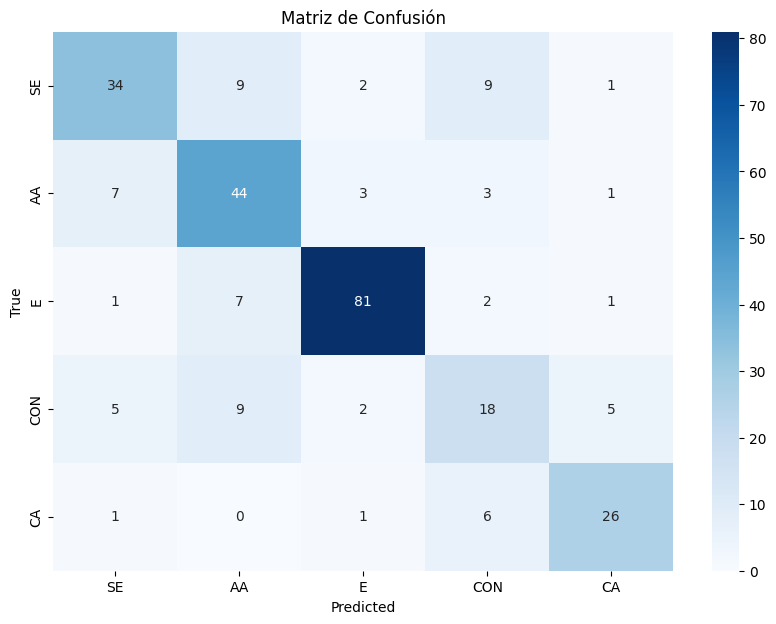

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()